In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
fake_data1 = pd.read_csv("../data/Fake and real news dataset/Fake.csv")
true_data1 = pd.read_csv("../data/Fake and real news dataset/True.csv")

In [13]:
#true_data1.shape
#true_data1.head()
#checking for invalid entries
true_data1.isnull().values.any()

False

In [14]:
#fake_data1.shape
#fake_data1.head()
#checking for invalid entries
fake_data1.isnull().values.any()

False

In [15]:
#true_data1[['title', 'text']]
#fake_data1[['title', 'text']]

In [16]:
def plot_top_counts(titles, top, plt_title):
    

    #titles = fake_data1['title']
    title_words = {}
    word = ""

    for title in titles:
        title = title.split(" ")

        for word in title:
            word = word.strip()
            word = word.strip(",")
            word = word.strip(".")
            word = word.strip("'")
            word = word.strip(":")

            if word.isalpha():
                if word not in title_words:
                    title_words[word] = 1
                else:
                    title_words[word] += 1

    sorted_words = sorted(title_words.items(), key = lambda x: x[1], reverse = True)
    plotting_words = sorted_words[0:top]
    words_x = [tup[0] for tup in plotting_words]
    counts_y = [tup[1] for tup in plotting_words]

    
    
    plt.bar(range(len(plotting_words)), counts_y)
    plt.xticks(range(len(plotting_words)), words_x)
    plt.xlabel("Words")
    plt.ylabel("Counts")
    plt.title(plt_title)
    plt.show()




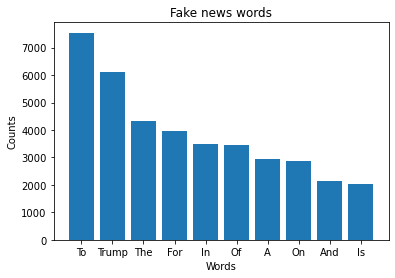

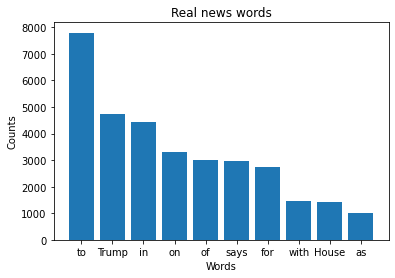

In [17]:
true_titles = true_data1['title']
fake_titles = fake_data1['title']
plot_top_counts(fake_titles, 10, "Fake news words")
plot_top_counts(true_titles, 10, "Real news words")
#write comment about hwo this data set is heavility based of articles from the US politiacal...

In [18]:
#merging the fake and true datasets and adding a new column indicating where its fake or true

is_fake = [1 for x in range(len(fake_data1))]
fake_data1['is_fake'] = is_fake

is_fake = [0 for x in range(len(true_data1))]
true_data1['is_fake'] = is_fake

frames = [true_data1, fake_data1]
merged1 = pd.concat(frames)

merged1.describe
merged1 = sk.utils.shuffle(merged1)
merged1.head()

#splitting data into training and tests sets
split = 0.2
train_tles, test_tles, train_tles_res, test_tles_res = train_test_split(merged1['title'], merged1['is_fake'], test_size=split, random_state=12)
train_txts, test_txts, train_txts_res, test_txts_res = train_test_split(merged1['text'], merged1['is_fake'], test_size=split, random_state=12)

#print(len(train_txts))
#print(len(train_res_txts))
#print(len(test_tles))


In [20]:
#creating a word dictionaries where each word is assigned a unique number 

#tokenizer for titles set
n_words = 10000
tokenizer_tles = tf.keras.preprocessing.text.Tokenizer(
    num_words = n_words, filters='!""#$%&()*+,-./:;<=>?@[\\]^_`{|}\'~\t\n.', lower=True,
    split=' ', char_level=False,  oov_token=True)

tokenizer_tles.fit_on_texts(train_tles)
train_tles_seqs = tokenizer_tles.texts_to_sequences(train_tles)

max_tle_len = max(len(x) for x in train_tles_seqs)

train_tles_seqs = sequence.pad_sequences(train_tles_seqs, maxlen=max_tle_len)
test_tles_seqs = tokenizer_tles.texts_to_sequences(test_tles)
test_tles_seqs = sequence.pad_sequences(test_tles_seqs, maxlen=max_tle_len)



#tokenizer for texts set
tokenizer_txts = tf.keras.preprocessing.text.Tokenizer(
    num_words = n_words, filters='!""#$%&()*+,-./:;<=>?@[\\]^_`{|}\'~\t\n.', lower=True,
    split=' ', char_level=False,  oov_token=True)

tokenizer_txts.fit_on_texts(train_txts)
train_txts_seqs = tokenizer_txts.texts_to_sequences(train_txts)

max_txt_len = max(len(x) for x in train_txts_seqs)

train_txts_seqs = sequence.pad_sequences(train_txts_seqs, maxlen=max_txt_len)
test_txts_seqs = tokenizer_txts.texts_to_sequences(test_txts)
test_txts_seqs = sequence.pad_sequences(test_txts_seqs, maxlen=max_txt_len)




In [42]:

print(max_tle_len)

print(max_txt_len)


44
8375


In [43]:
print(max(tokenizer_tles.word_index.values()))
print(len(train_tles))


26934
35918


In [44]:
#building model for analysing titles
#experiment with this 
inp_dim = max(tokenizer_tles.word_index.values()) + 1
out_dim = 24

model_tles = Sequential()
model_tles.add(Embedding(inp_dim, out_dim, input_length=max_tle_len))
model_tles.add(Flatten())
model_tles.add(Dense(8, activation='relu'))
model_tles.add(Dense(8, activation='relu'))
model_tles.add(Dense(1, activation='sigmoid'))
model_tles.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model_tles.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 44, 24)            646440    
_________________________________________________________________
flatten_4 (Flatten)          (None, 1056)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 8456      
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 654,977
Trainable params: 654,977
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
print(len(train_tles_seqs))
print(len(train_tles_res))

35918
35918


In [46]:
#fitting model for predicting if a title is part of a fake news article or not
hist_tles = model_tles.fit(train_tles_seqs, train_tles_res, validation_data=(test_tles_seqs, test_tles_res), epochs=3, batch_size=128)

Train on 35918 samples, validate on 8980 samples
Epoch 1/3
35918/35918 [==============================] - 7s 197us/step - loss: 0.2742 - accuracy: 0.9053 - val_loss: 0.0896 - val_accuracy: 0.9666
Epoch 2/3
35918/35918 [==============================] - 6s 153us/step - loss: 0.0561 - accuracy: 0.9814 - val_loss: 0.0634 - val_accuracy: 0.9767
Epoch 3/3
35918/35918 [==============================] - 5s 149us/step - loss: 0.0274 - accuracy: 0.9917 - val_loss: 0.0639 - val_accuracy: 0.9759


In [47]:
print(hist_tles.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


Accuracy: 97.59%


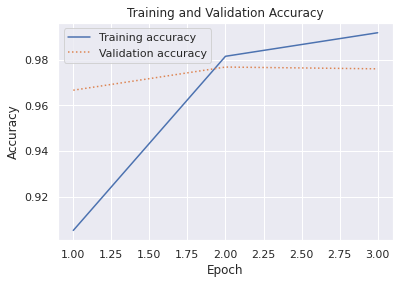

In [48]:

#%matplotlib inline

sns.set()
acc = hist_tles.history['accuracy']
val = hist_tles.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

scores_tles = model_tles.evaluate(test_tles_seqs, test_tles_res, verbose=0)
print("Accuracy: %.2f%%" % (scores_tles[1] * 100))

In [49]:
#building model for analysing texts
inp_dim = max(tokenizer_txts.word_index.values()) + 1
out_dim = 24

model_txts = Sequential()
model_txts.add(Embedding(inp_dim, out_dim, input_length=max_txt_len))
model_txts.add(Flatten())
model_txts.add(Dense(8, activation='relu'))
model_txts.add(Dense(8, activation='relu'))
model_txts.add(Dense(1, activation='sigmoid'))
model_txts.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model_txts.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 8375, 24)          2997600   
_________________________________________________________________
flatten_5 (Flatten)          (None, 201000)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 1608008   
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 4,605,689
Trainable params: 4,605,689
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#fitting model for predicting a text/article body is fake or not
hist_txts = model_txts.fit(train_txts_seqs, train_txts_res, validation_data=(test_txts_seqs, test_txts_res), epochs=5, batch_size=128)

Train on 35918 samples, validate on 8980 samples
Epoch 1/5
17920/35918 [=============>................] - ETA: 27s - loss: 0.5598 - accuracy: 0.7118

In [ ]:

#%matplotlib inline

sns.set()
acc = hist_txts.history['accuracy']
val = hist_txts.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.plot()

scores_tles = hist_txts.evaluate(test_txts_seqs, test_txts_res, verbose=0)
print("Accuracy: %.2f%%" % (scores_tles[1] * 100))